In [1]:
print('Kaggle NLP Analysis')
print('https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data')

Kaggle NLP Analysis
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data


In [1]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
lemmatizer = WordNetLemmatizer()

from textblob import TextBlob
from textblob import Word

# set random seed for the session and also for tensorflow that runs in background for keras
set_random_seed(123)
random.seed(123)

Using TensorFlow backend.


In [3]:
# load data
train= pd.read_csv('C:/Users/madmo/OneDrive/Syracuse/IST736 - TextMin/Homework/Homework7/sentiment-analysis-on-movie-reviews/traintsv.tsv', sep="\t")
test = pd.read_csv('C:/Users/madmo/OneDrive/Syracuse/IST736 - TextMin/Homework/Homework7/sentiment-analysis-on-movie-reviews/testtsv.tsv', sep="\t")

# check head of train data
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
# check shape of train data
train.shape

(156060, 4)

In [5]:
# check head of test data
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [6]:
# define a function to clean phrase columns
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [7]:
# cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████████████████████████████████████████████████████████████████████| 66292/66292 [00:19<00:00, 3441.69it/s]


156060
66292


In [8]:
# collect cependent values and convert to encoded output using to_categorical
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [9]:
# creat validation sets
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [10]:
# https://keras.io/preprocessing/text/
# review number of unique words
# needed to initialize tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
# length of the list of unique_words gives number of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████████████████████████████████████████████████████████████████| 124848/124848 [00:00<00:00, 691614.61it/s]


13734
48


In [11]:
# keras tokenizer and coversion to sequences
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

# padding done to equalize lengths of all input reviews 
# LSTM networks needs all inputs to be same length
# reviews less than max length will be made equal using extra zeros at end - this is padding
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [12]:
# stopping method to prevent overfitting
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

# model using Keras LSTM
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

W0827 19:54:19.378288 20520 deprecation_wrapper.py:119] From C:\Users\madmo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 19:54:19.382280 20520 deprecation_wrapper.py:119] From C:\Users\madmo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 19:54:19.384273 20520 deprecation_wrapper.py:119] From C:\Users\madmo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 19:54:19.495974 20520 deprecation_wrapper.py:119] From C:\Users\madmo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0827 19:54:19.501959 20520 deprecation.py:506

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 300)           4120200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 4,396,261
Trainable params: 4,396,261
Non-trainable params: 0
_________________________________________________________________


In [13]:
print('#############################################################################')
print('############################### Code from HW 6 ##############################')
print('#############################################################################')

#############################################################################
############################### Code from HW 6 ##############################
#############################################################################


In [2]:
## Libraries ##
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import pprint

import nltk
import sklearn
import re  
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
## For Stemming ##
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import os
import seaborn as sns
from textblob import TextBlob
from textblob import Word
plt.style.use('classic')
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string

from nltk.tokenize import WordPunctTokenizer

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.cluster import KMeans
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer

from nltk import bigrams
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn import model_selection

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\madmo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Training Set Sentiment Distribution: Mostly Neutral


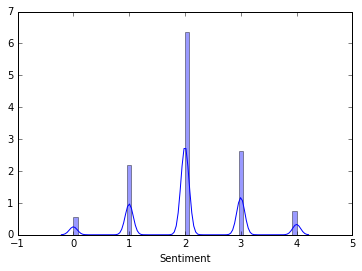

In [15]:
sns.distplot(train.Sentiment)
print('Training Set Sentiment Distribution: Mostly Neutral')

Frequency of Sentiment Values


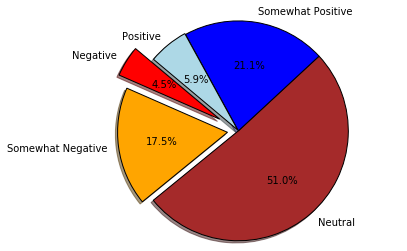

In [16]:
print('Frequency of Sentiment Values')

negative = train[train.Sentiment == 0]
somewhatnegative = train[train.Sentiment == 1]
neutral = train[train.Sentiment == 2]
somewhatpositive = train[train.Sentiment == 3]
positive = train[train.Sentiment == 4]

# data to plot
labels = 'Negative', 'Somewhat Negative','Neutral','Somewhat Positive','Positive'
sizes = [len(negative),len(somewhatnegative), len(neutral),len(somewhatpositive),len(positive)]
colors = ['red', 'orange','brown','blue','lightblue']
explode = (0.2, 0.1,0.0,0.0,0.01)  # explode 1st slice
 
# plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [17]:
# cleaning data
# lower string
train['Phrase'] = train['Phrase'].str.lower()
# remove email adress
train['Phrase'] = train['Phrase'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)
# remove IP address
train['Phrase'] = train['Phrase'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)
# remove punctuations and special characters
train['Phrase'] = train['Phrase'].str.replace('[^\w\s]','')

# remove numbers
train['Phrase'] = train['Phrase'].replace('\d', '', regex=True)

# remove stopwords
stop = stopwords.words('english')
train = train[train['Phrase'].notnull()]
train['Phrase'] = train['Phrase'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


In [18]:
print('Cleaned Dataframe')
train.head()

Cleaned Dataframe


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
3,4,1,,2
4,5,1,series,2


In [19]:
# remove stopwords
stop = stopwords.words('english')

train['stopwords'] = train['Phrase'].apply(lambda x: len([x for x in x.split() if x in stop]))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,stopwords
0,1,1,series escapades demonstrating adage good goos...,1,0
1,2,1,series escapades demonstrating adage good goose,2,0
2,3,1,series,2,0
3,4,1,,2,0
4,5,1,series,2,0


In [20]:
train = train.dropna()

Checking for Stopwords


C:\Users\madmo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\madmo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



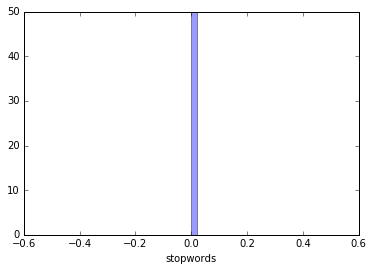

In [21]:
print('Checking for Stopwords')
sns.distplot(train.stopwords)

In [22]:
# word count
train['word_count'] = train['Phrase'].apply(lambda x: len(str(x).split(" ")))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,stopwords,word_count
0,1,1,series escapades demonstrating adage good goos...,1,0,15
1,2,1,series escapades demonstrating adage good goose,2,0,6
2,3,1,series,2,0,1
3,4,1,,2,0,1
4,5,1,series,2,0,1


Distribution of Number of Words used in Phrases


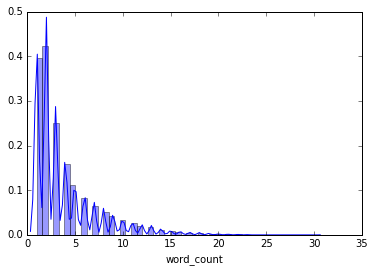

In [23]:
print('Distribution of Number of Words used in Phrases')
sns.distplot(train.word_count)

In [24]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Words used in Phrases


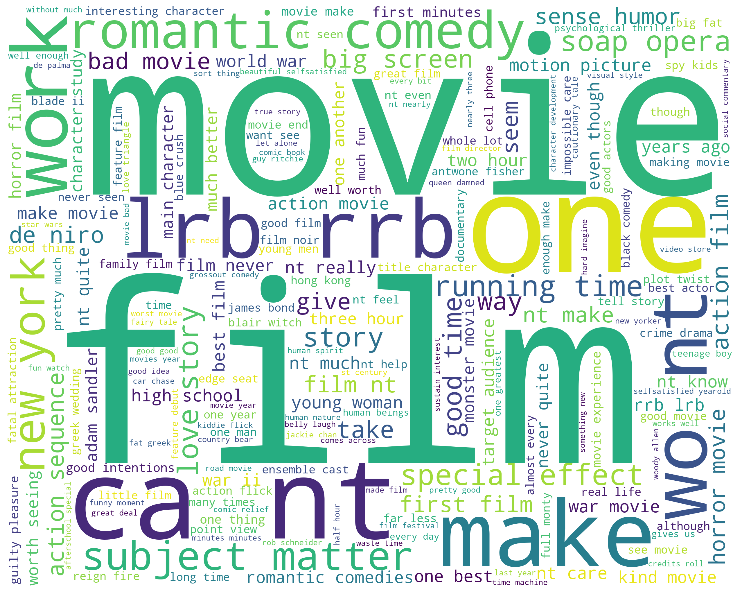

In [37]:
# words used
print("Words used in Phrases")
wordcloud_draw(train.Phrase,'white')

In [38]:
print('#############################################################################')
print('#############################################################################')
print('#############################################################################')

#############################################################################
#############################################################################
#############################################################################


In [3]:
### Textmining Naive Bayes Example ###
import nltk
import pandas as pd
import sklearn
import re  
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
## For Stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import os

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
import numpy as np

In [4]:
# build  vectorizer
# pattern='r/^[a-zA-Z]{4}$/'
# pattern="[^r\P{P}]+"

MyVect5=CountVectorizer(input='phraseId',
                        analyzer = 'word',
                        stop_words='english',
                        #token_pattern='(?u)[a-zA-Z]+',
                        #token_pattern=pattern,
                        #tokenizer=LemmaTokenizer(),
                        #strip_accents = 'unicode', 
                        lowercase = True
                        )

MyVect5B=CountVectorizer(input='phraseId',
                        analyzer = 'word',
                        stop_words='english',
                        #token_pattern='(?u)[a-zA-Z]+',
                        #token_pattern=pattern,
                        #tokenizer=LemmaTokenizer(),
                        #strip_accents = 'unicode', 
                        lowercase = True,
                        binary=True
                        )

In [27]:
# load data set
print('Since the initial Test set has no Sentiment Labels at All')
print('Using the Train set as a Master set')
print('Splitting it into Test and Train')
df= pd.read_csv('C:/Users/madmo/OneDrive/Syracuse/IST736 - TextMin/Homework/Homework7/sentiment-analysis-on-movie-reviews/traintsv.tsv', sep="\t")


Since the initial Test set has no Sentiment Labels at All
Using the Train set as a Master set
Splitting it into Test and Train


In [28]:
# cleaning DF
# lower string
df['Phrase'] = df['Phrase'].str.lower()
# remove email adress
df['Phrase'] = df['Phrase'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)
# remove IP address
df['Phrase'] = df['Phrase'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)
# remove punctuations and special characters
df['Phrase'] = df['Phrase'].str.replace('[^\w\s]','')

# remove numbers
df['Phrase'] = df['Phrase'].replace('\d', '', regex=True)

# remove stopwords
stop = stopwords.words('english')
df = df[df['Phrase'].notnull()]
df['Phrase'] = df['Phrase'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [29]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
3,4,1,,2
4,5,1,series,2


In [30]:
df.shape

(156060, 4)

In [31]:
from sklearn.model_selection import train_test_split

TrainDF, TestDF = train_test_split(df, test_size=0.3)

In [32]:
####################################################################
########################### Naive Bayes ############################
####################################################################
from sklearn.naive_bayes import MultinomialNB
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.fit

In [33]:
# vectorize
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df['Phrase'])

In [34]:
encoder = LabelEncoder()
y = encoder.fit_transform(df['Sentiment'])

In [35]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, shuffle=True)

In [36]:
# look at the shape of each
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(62424, 16063)
(62424,)
(93636, 16063)
(93636,)


In [37]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

In [38]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

In [39]:
print(vectorizer.get_feature_names())

['aaa', 'aaliyah', 'aan', 'abagnale', 'abandon', 'abandoned', 'abbass', 'abbott', 'abbreviated', 'abc', 'abderrahmane', 'abdul', 'abel', 'abhorrent', 'abhors', 'abiding', 'abilities', 'ability', 'abject', 'able', 'ably', 'abomination', 'aboriginal', 'abornin', 'aborted', 'abound', 'aboveaverage', 'abrasive', 'abridged', 'abroad', 'abrupt', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbing', 'absorbs', 'abstract', 'absurd', 'absurdist', 'absurdities', 'absurdity', 'absurdly', 'abundant', 'abundantly', 'abuse', 'abused', 'abysmal', 'abysmally', 'abyss', 'ac', 'academic', 'academy', 'accent', 'accents', 'accentuating', 'accept', 'acceptable', 'acceptance', 'accepting', 'accepts', 'access', 'accessibility', 'accessible', 'accident', 'accidental', 'accidentprone', 'acclaim', 'acclaimed', 'accommodate', 'accomodates', 'accompanied', 'accompanies', 'accompanying', 'accomplish', 'accomplished', 'accomplishes', 'accomplishment', 'accomplishments', 'according', 'acc

IndexError: index 46644 is out of bounds for axis 0 with size 16063

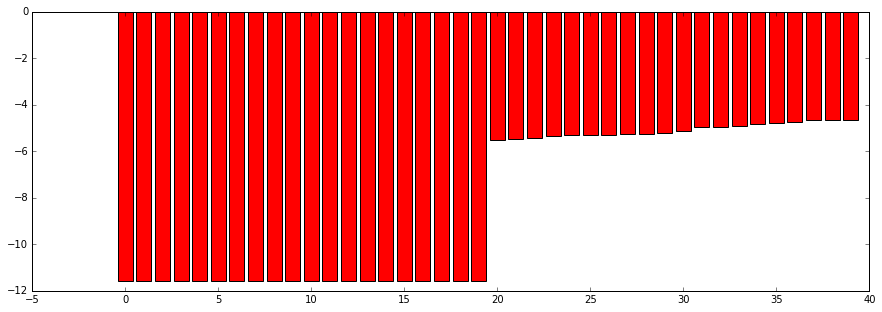

In [40]:
plot_coefficients(nb, vectorizer.get_feature_names())

In [41]:
nb.score(x_test, y_test)

0.5893246187363834

In [42]:
print(accuracy_score(y_test, y_pred))

0.5893246187363834


In [43]:
coefs = nb.coef_
print(coefs.shape)
print(coefs)

(5, 16063)
[[-10.41661054 -10.41661054 -10.41661054 ... -10.41661054 -10.41661054
   -9.03031617]
 [-11.13321582 -11.13321582 -11.13321582 ... -11.13321582 -11.13321582
  -11.13321582]
 [-10.89555344  -9.97926271 -11.58870062 ...  -9.79694115 -10.49008833
  -11.58870062]
 [-11.24994901 -11.24994901 -11.24994901 ... -10.55680183 -10.55680183
  -11.24994901]
 [ -9.82368648 -10.51683366 -10.51683366 ... -10.51683366 -10.51683366
  -10.51683366]]


In [44]:
print(confusion_matrix(y_test,y_pred))

[[  901  2012  1150   141    15]
 [  826  6490  7996  1026    44]
 [  355  4388 36771  5859   377]
 [   50   776  8082  9800  1015]
 [    2   103   989  3248  1220]]


In [45]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

[[  901  2012  1150   141    15]
 [  826  6490  7996  1026    44]
 [  355  4388 36771  5859   377]
 [   50   776  8082  9800  1015]
 [    2   103   989  3248  1220]]


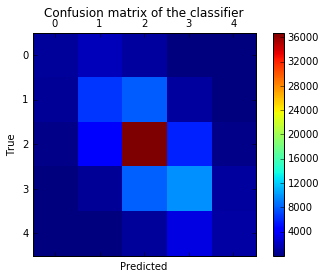

In [46]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

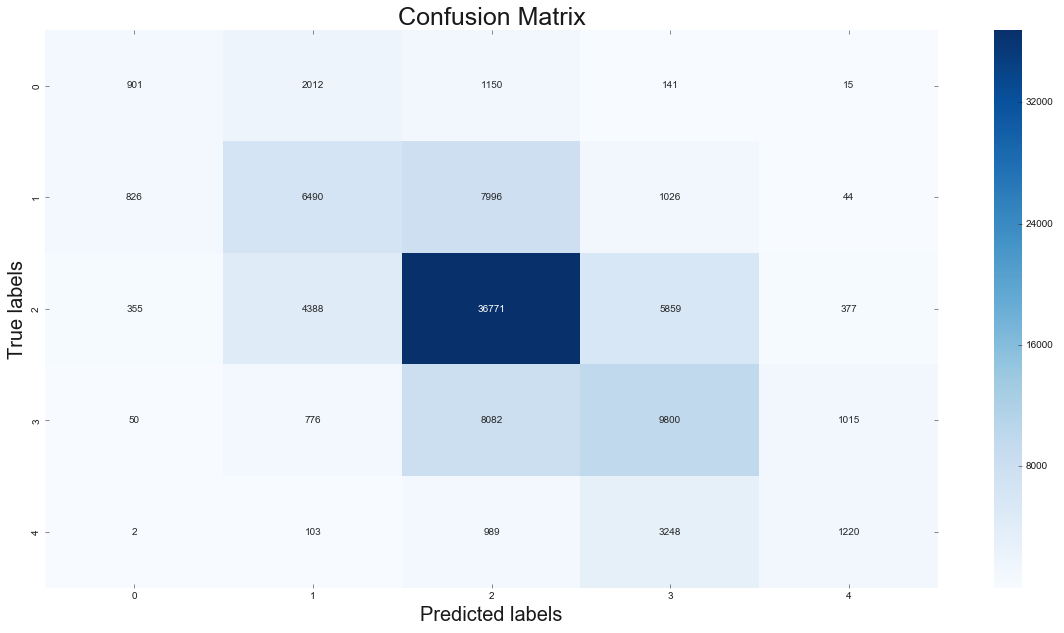

In [47]:
plt.figure(figsize=(20, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title, and ticks
sns.set(font_scale=1)
ax.set_xlabel('Predicted labels', size=20);ax.set_ylabel('True labels',size=20); 
ax.set_title('Confusion Matrix',size=25); 


In [48]:
y_pred_prob = nb.predict_proba(x_test)[:,1]

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.21      0.28      4219
           1       0.47      0.40      0.43     16382
           2       0.67      0.77      0.72     47750
           3       0.49      0.50      0.49     19723
           4       0.46      0.22      0.30      5562

    accuracy                           0.59     93636
   macro avg       0.50      0.42      0.44     93636
weighted avg       0.57      0.59      0.57     93636



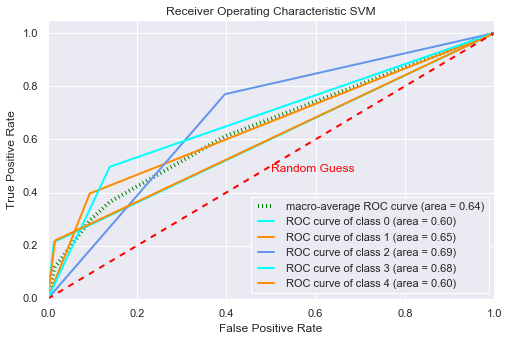

In [50]:
n_classes =5
t1=sum(x==0 for x in y_pred-y_test)/len(y_pred)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle
from sklearn.naive_bayes import GaussianNB


sns.set(font_scale=1)
### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_pred))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
ll_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic SVM')
plt.legend(loc="lower right")
plt.show()




In [51]:
print('#########################################################################')
print('############################ SVM - Multiclass ###########################')
print('#########################################################################')

#########################################################################
############################ SVM - Multiclass ###########################
#########################################################################


In [52]:
print('SVM - Multiclass')

SVM - Multiclass


In [53]:
df= pd.read_csv('C:/Users/madmo/OneDrive/Syracuse/IST736 - TextMin/Homework/Homework7/sentiment-analysis-on-movie-reviews/traintsv.tsv', sep="\t")
# vectorize
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df['Phrase'])
encoder = LabelEncoder()
y = encoder.fit_transform(df['Sentiment'])

In [54]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.60, shuffle=True)

In [16]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

In [56]:
from sklearn.svm import LinearSVC
SVM_Model=LinearSVC(C=300,max_iter=1000,random_state=12345)
SVM_Model.fit(x_train, y_train)
# BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
y_pred = SVM_Model.predict(x_test)
print("SVM prediction:\n", SVM_Model.predict(x_test))
print("Actual:")
print(y_test)

C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



SVM prediction:
 [3 2 3 ... 2 2 2]
Actual:
[1 2 2 ... 2 2 0]


In [57]:
print(vectorizer.get_feature_names())

['000', '10', '100', '101', '102', '103', '104', '105', '10th', '11', '110', '112', '12', '120', '127', '129', '12th', '13', '13th', '14', '140', '146', '15', '15th', '16', '163', '168', '170', '1790', '18', '1899', '19', '1915', '1920', '1930s', '1933', '1937', '1938', '1940s', '1950', '1950s', '1952', '1953', '1957', '1958', '1959', '1960', '1960s', '1962', '1970', '1970s', '1971', '1972', '1973', '1975', '1979', '1980', '1980s', '1984', '1986', '1987', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1997', '1998', '1999', '19th', '20', '2000', '2001', '2002', '20th', '21', '21st', '22', '24', '2455', '25', '26', '270', '295', '30', '300', '3000', '30s', '37', '3d', '40', '40s', '42', '451', '48', '4ever', '4th', '4w', '50', '500', '50s', '51', '51st', '52', '53', '5ths', '60', '60s', '65', '65th', '66', '70', '70s', '71', '72', '75', '77', '78', '7th', '80', '800', '80s', '83', '84', '85', '86', '87', '88', '89', '8th', '90', '90s', '91', '93', '94', '95', '96', '98', '99',

In [58]:
SVM_Model.fit(x_train, y_train)

LinearSVC(C=300, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=12345, tol=0.0001,
          verbose=0)

IndexError: index 36827 is out of bounds for axis 0 with size 15240

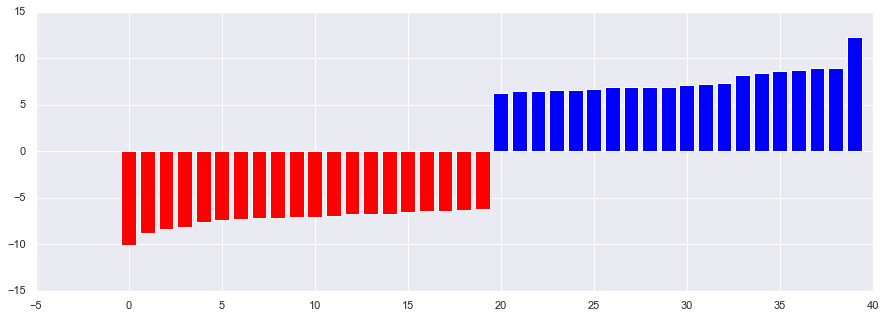

In [59]:
plot_coefficients(SVM_Model, vectorizer.get_feature_names())

In [60]:
SVM_Model.score(x_test, y_test)

0.5884488871801444

In [61]:
cmtrx = confusion_matrix(y_test,y_pred)
cmtrx

array([[ 1539,  1728,   682,   236,    25],
       [ 1800,  6498,  6614,  1464,   122],
       [  784,  4754, 35776,  5977,   434],
       [  168,  1083,  7255,  9508,  1665],
       [   45,   147,   707,  2846,  1779]], dtype=int64)

[[ 1539  1728   682   236    25]
 [ 1800  6498  6614  1464   122]
 [  784  4754 35776  5977   434]
 [  168  1083  7255  9508  1665]
 [   45   147   707  2846  1779]]


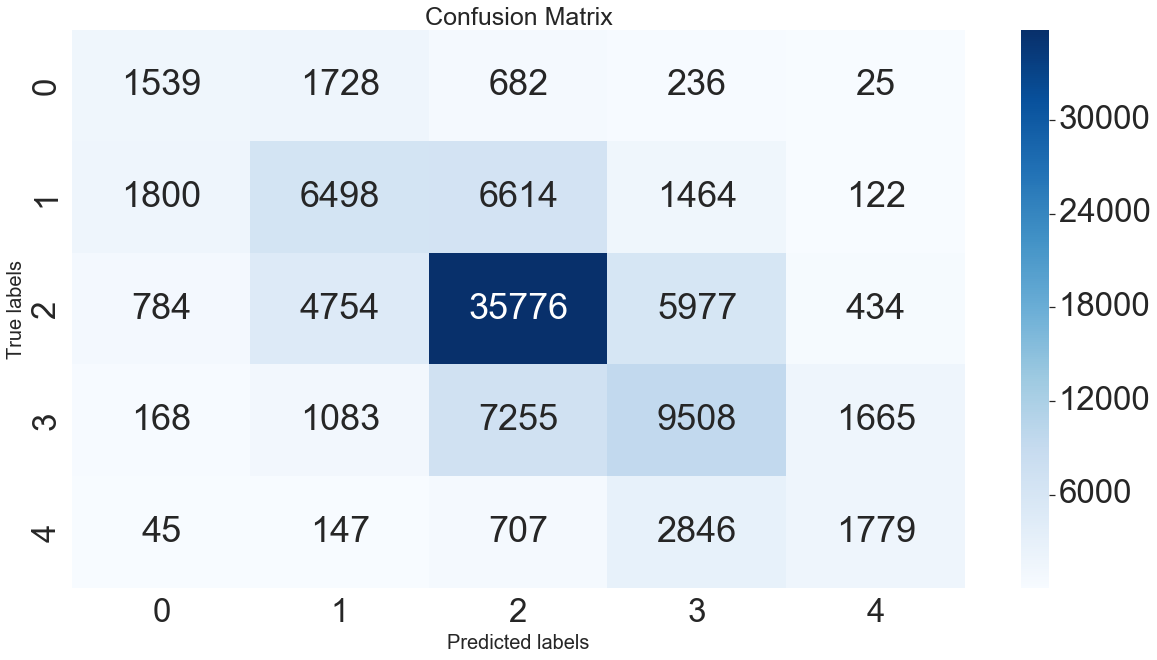

In [63]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(20, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title, and ticks
sns.set(font_scale=3)
ax.set_xlabel('Predicted labels', size=20);ax.set_ylabel('True labels',size=20); 
ax.set_title('Confusion Matrix',size=25); 

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.37      0.36      4210
           1       0.46      0.39      0.42     16498
           2       0.70      0.75      0.72     47725
           3       0.47      0.48      0.48     19679
           4       0.44      0.32      0.37      5524

    accuracy                           0.59     93636
   macro avg       0.49      0.46      0.47     93636
weighted avg       0.58      0.59      0.58     93636



In [65]:
n_classes =5

In [66]:
t1=sum(x==0 for x in y_pred-y_test)/len(y_pred)

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle
from sklearn.naive_bayes import GaussianNB



### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_pred))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [68]:
ll_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


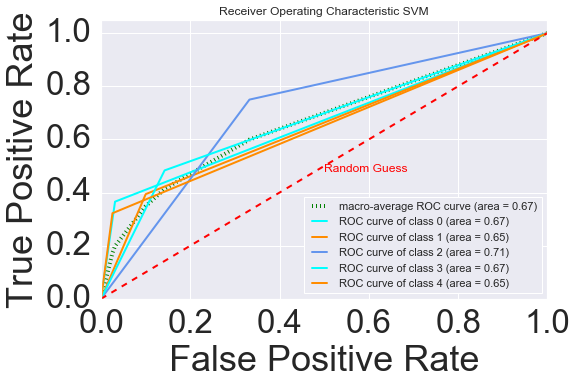

In [69]:
lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
sns.set(font_scale=1)
plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic SVM')
plt.legend(loc="lower right")
plt.show()

In [70]:
print('#########################################################################')
print('############################### SVM NGRAM ###############################')
print('#########################################################################')

#########################################################################
############################### SVM NGRAM ###############################
#########################################################################


In [34]:
df= pd.read_csv('C:/Users/madmo/OneDrive/Syracuse/IST736 - TextMin/Homework/Homework7/sentiment-analysis-on-movie-reviews/traintsv.tsv', sep="\t")
# vectorize
vectorizer = CountVectorizer(ngram_range=(2,2))
x = vectorizer.fit_transform(df['Phrase'])
encoder = LabelEncoder()
y = encoder.fit_transform(df['Sentiment'])

In [35]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.60, shuffle=True)

In [36]:
from sklearn.svm import LinearSVC
SVM_Model=LinearSVC(C=300,max_iter=1000,random_state=12345)
SVM_Model.fit(x_train, y_train)
# BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
y_pred = SVM_Model.predict(x_test)
print("SVM prediction:\n", SVM_Model.predict(x_test))
print("Actual:")
print(y_test)

C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



SVM prediction:
 [2 4 2 ... 2 4 2]
Actual:
[2 3 2 ... 1 4 2]


In [37]:
print(vectorizer.get_feature_names())

['000 leagues', '000 times', '10 000', '10 but', '10 course', '10 minutes', '10 or', '10 seconds', '10 set', '10 the', '10 year', '10 years', '100 minute', '100 minutes', '100 year', '100 years', '101 in', '101 minutes', '101 premise', '101 study', '102 minute', '103 minute', '104 minutes', '105 minutes', '10th film', '10th grade', '11 new', '11 period', '11 rrb', '11 terrorist', '11 the', '11 times', '11 years', '110 claustrophobic', '110 minutes', '112 minute', '12 shot', '12 year', '120 and', '127 years', '129 minute', '12th oscar', '13 conversations', '13 in', '13 months', '13 rating', '13 was', '13 yet', '13th by', '14 year', '140 minutes', '146 minutes', '15 minutes', '15 year', '15 years', '15th century', '163 minutes', '168 minute', '170 minutes', '1790 one', '18 or', '18 year', '19 jettisoned', '19 sinks', '19 stays', '19 that', '19 the', '19 will', '1915 armenia', '1915 with', '1920 the', '1930s horror', '1937 breakthrough', '1940s warner', '1950 doris', '1950s and', '1950s s

In [38]:
SVM_Model.fit(x_train, y_train)

LinearSVC(C=300, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=12345, tol=0.0001,
          verbose=0)

IndexError: index 201403 is out of bounds for axis 0 with size 79404

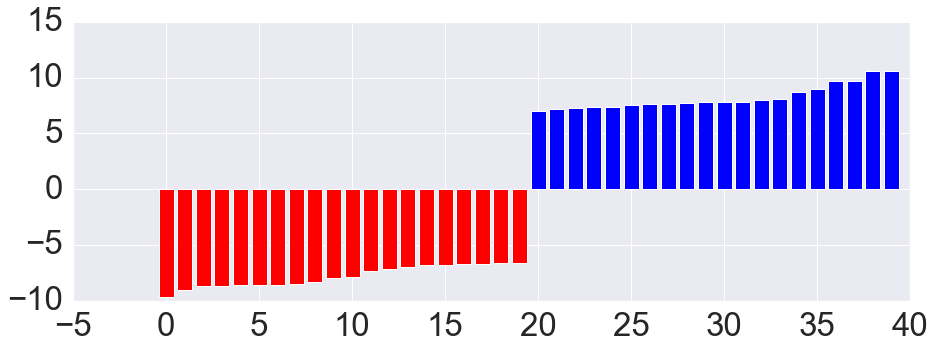

In [39]:
plot_coefficients(SVM_Model, vectorizer.get_feature_names())

In [40]:
SVM_Model.score(x_test, y_test)

0.5774702037677816

In [41]:
cmtrx = confusion_matrix(y_test,y_pred)
cmtrx

array([[ 1343,  1674,  1073,   134,    47],
       [ 1466,  6457,  7393,   788,   183],
       [  622,  4917, 36336,  5184,   739],
       [  134,   870,  8582,  7824,  2308],
       [   23,   110,  1084,  2233,  2112]], dtype=int64)

[[ 1343  1674  1073   134    47]
 [ 1466  6457  7393   788   183]
 [  622  4917 36336  5184   739]
 [  134   870  8582  7824  2308]
 [   23   110  1084  2233  2112]]


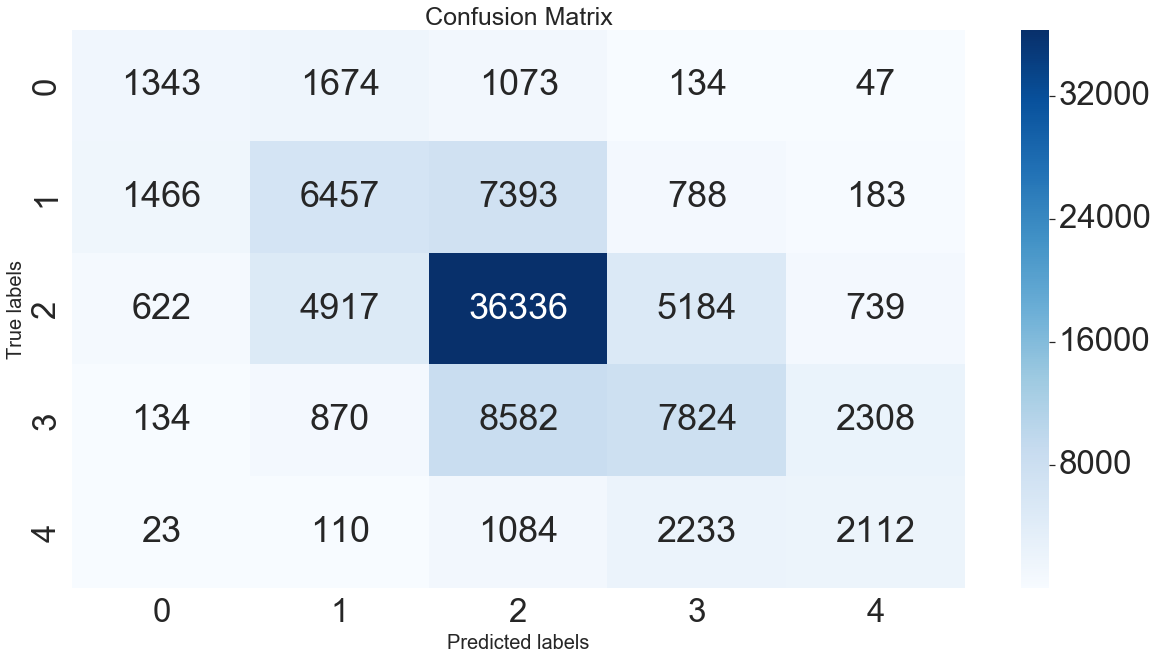

In [42]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(20, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title, and ticks
sns.set(font_scale=3)
ax.set_xlabel('Predicted labels', size=20);ax.set_ylabel('True labels',size=20); 
ax.set_title('Confusion Matrix',size=25); 

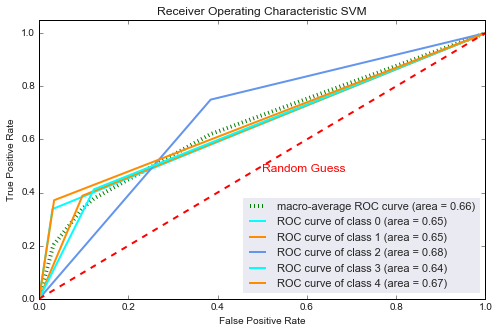

In [15]:
n_classes =5
t1=sum(x==0 for x in y_pred-y_test)/len(y_pred)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle
from sklearn.naive_bayes import GaussianNB



### MACRO ###
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_pred))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

ll_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
sns.set(font_scale=1)
plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic SVM')
plt.legend(loc="lower right")
plt.show()

In [81]:
print('#########################################################################')
print('########################### MNB Multiclass ##############################')
print('#########################################################################')

#########################################################################
########################### MNB Multiclass ##############################
#########################################################################


In [29]:
df= pd.read_csv('C:/Users/madmo/OneDrive/Syracuse/IST736 - TextMin/Homework/Homework7/sentiment-analysis-on-movie-reviews/traintsv.tsv', sep="\t")
# computing a compund sentiment
TrainDF, TestDF = train_test_split(df, test_size=1)

In [30]:
# vectorize
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df['Phrase'])
encoder = LabelEncoder()
y = encoder.fit_transform(df['Sentiment'])
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, shuffle=True)
# look at the shape of each
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(62424, 15240)
(62424,)
(93636, 15240)
(93636,)


In [31]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
nb.score(x_test, y_test)

0.5932974496988338

In [32]:
print(confusion_matrix(y_test,y_pred))

[[  879  2091  1012   164    21]
 [  832  7022  7403  1055    59]
 [  361  4713 36661  5715   413]
 [   36   815  8085  9692  1031]
 [    7   106   990  3173  1300]]


[[  879  2091  1012   164    21]
 [  832  7022  7403  1055    59]
 [  361  4713 36661  5715   413]
 [   36   815  8085  9692  1031]
 [    7   106   990  3173  1300]]


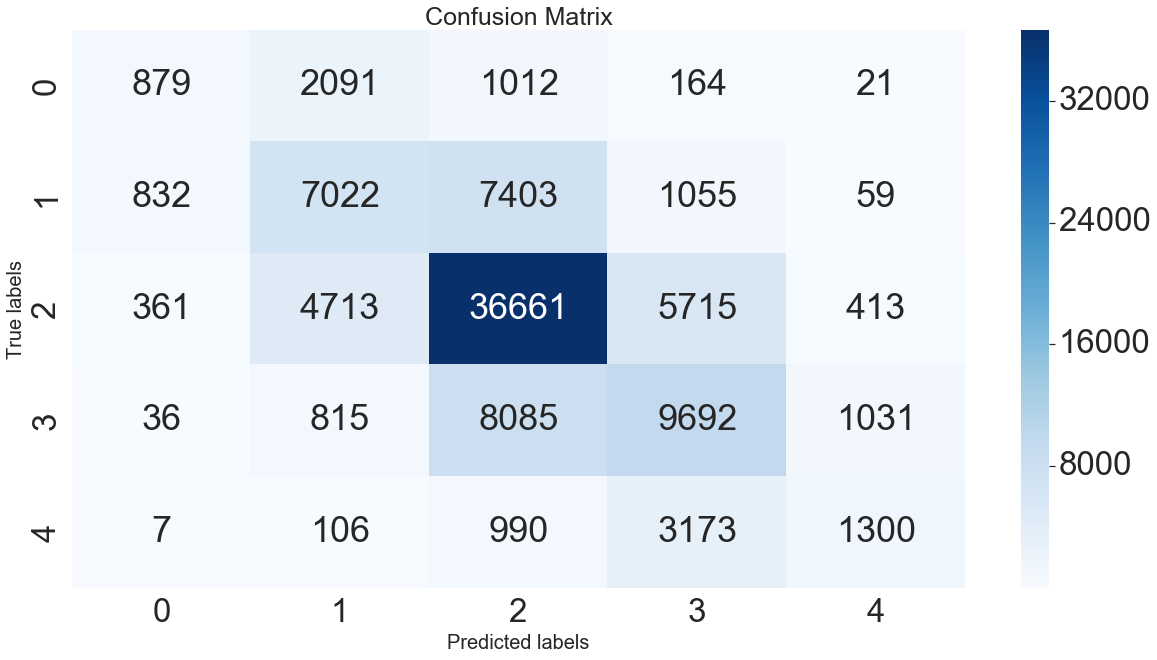

In [33]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(20, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title, and ticks
sns.set(font_scale=3)
ax.set_xlabel('Predicted labels', size=20);ax.set_ylabel('True labels',size=20); 
ax.set_title('Confusion Matrix',size=25); 

In [87]:
y_pred_prob = nb.predict_proba(x_test)[:,1]

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.21      0.28      4247
           1       0.47      0.43      0.45     16289
           2       0.68      0.77      0.72     47816
           3       0.50      0.49      0.49     19809
           4       0.45      0.24      0.31      5475

    accuracy                           0.60     93636
   macro avg       0.50      0.43      0.45     93636
weighted avg       0.58      0.60      0.58     93636



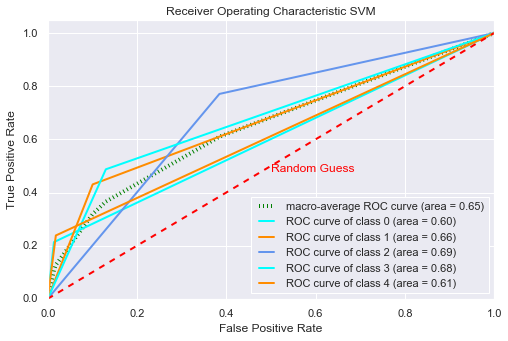

In [89]:
n_classes =5
t1=sum(x==0 for x in y_pred-y_test)/len(y_pred)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle
from sklearn.naive_bayes import GaussianNB



### MACRO ###
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_pred))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
ll_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw=2
sns.set(font_scale=1)
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic SVM')
plt.legend(loc="lower right")
plt.show()



In [90]:
print('#########################################################################')
print('########################## MNB Multiclass NGram #########################')
print('#########################################################################')

#########################################################################
########################## MNB Multiclass NGram #########################
#########################################################################


In [91]:
print('MNB Multiclass NGram')
print('Use Count Vectorize NGram Range to Adjust NGram Type')


MNB Multiclass NGram
Use Count Vectorize NGram Range to Adjust NGram Type


In [18]:
df= pd.read_csv('C:/Users/madmo/OneDrive/Syracuse/IST736 - TextMin/Homework/Homework7/sentiment-analysis-on-movie-reviews/traintsv.tsv', sep="\t")
# computing a compund sentiment 
TrainDF, TestDF = train_test_split(df, test_size=1)

In [23]:
# vectorize
vectorizer = CountVectorizer(ngram_range=(2,2))
x = vectorizer.fit_transform(df['Phrase'])
encoder = LabelEncoder()
y = encoder.fit_transform(df['Sentiment'])
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, shuffle=True)
# look at the shape of each
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(62424, 79404)
(62424,)
(93636, 79404)
(93636,)


In [24]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
nb.score(x_test, y_test)

0.5718527062241019

In [25]:
print(confusion_matrix(y_test,y_pred))

[[ 1385  1642  1072    90    33]
 [ 1516  6626  7390   846   104]
 [  669  5372 35293  5730   675]
 [  137   930  8289  8332  2017]
 [   22    84  1118  2354  1910]]


[[ 1385  1642  1072    90    33]
 [ 1516  6626  7390   846   104]
 [  669  5372 35293  5730   675]
 [  137   930  8289  8332  2017]
 [   22    84  1118  2354  1910]]


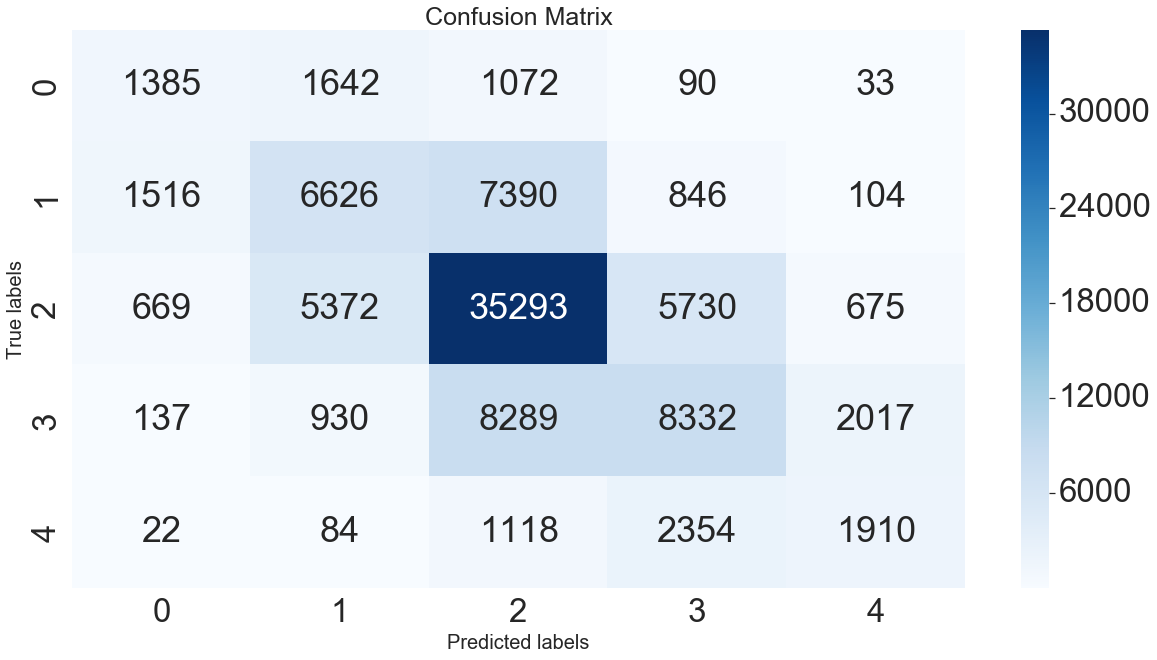

In [26]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(20, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title, and ticks
sns.set(font_scale=3)
ax.set_xlabel('Predicted labels', size=20);ax.set_ylabel('True labels',size=20); 
ax.set_title('Confusion Matrix',size=25); 

In [27]:
y_pred_prob = nb.predict_proba(x_test)[:,1]

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.33      0.35      4222
           1       0.45      0.40      0.43     16482
           2       0.66      0.74      0.70     47739
           3       0.48      0.42      0.45     19705
           4       0.40      0.35      0.37      5488

    accuracy                           0.57     93636
   macro avg       0.47      0.45      0.46     93636
weighted avg       0.56      0.57      0.56     93636



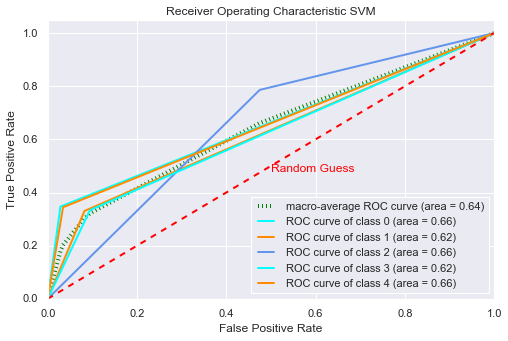

In [99]:
n_classes =5
t1=sum(x==0 for x in y_pred-y_test)/len(y_pred)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle
from sklearn.naive_bayes import GaussianNB



### MACRO ###
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_pred))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
ll_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw=2
sns.set(font_scale=1)
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic SVM')
plt.legend(loc="lower right")
plt.show()


In [100]:
#######################################################
##################### Tuning SVM ######################
#######################################################

In [5]:
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV, KFold
df= pd.read_csv('C:/Users/madmo/OneDrive/Syracuse/IST736 - TextMin/Homework/Homework7/sentiment-analysis-on-movie-reviews/traintsv.tsv', sep="\t")
# vectorize
vectorizer = CountVectorizer(ngram_range=(3,3))
x = vectorizer.fit_transform(df['Phrase'])
encoder = LabelEncoder()
y = encoder.fit_transform(df['Sentiment'])

In [6]:
from sklearn.svm import LinearSVC
SVM_Model=LinearSVC(C=300,max_iter=2000,random_state=12345)
SVM_Model.fit(x, y.ravel())
y_pred = SVM_Model.predict(x)
print("SVM prediction:\n", SVM_Model.predict(x))
print("Actual:")
print(y)
# 8 minutes!

C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



SVM prediction:
 [1 2 2 ... 2 2 2]
Actual:
[1 2 2 ... 3 2 2]


In [104]:
SVM_Model.score(x,y)

0.85959887222863

In [105]:
cmtrxSVM = confusion_matrix(y,y_pred)
cmtrxSVM

array([[ 5625,   560,   877,    10,     0],
       [  688, 20024,  6467,    91,     3],
       [  112,   899, 77499,  1014,    58],
       [    2,    82,  8088, 23881,   874],
       [    0,     4,  1254,   828,  7120]], dtype=int64)

In [106]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.80      0.83      7072
           1       0.93      0.73      0.82     27273
           2       0.82      0.97      0.89     79582
           3       0.92      0.73      0.81     32927
           4       0.88      0.77      0.82      9206

    accuracy                           0.86    156060
   macro avg       0.89      0.80      0.84    156060
weighted avg       0.87      0.86      0.86    156060



In [49]:
scoreSVMcv05 = cross_val_score(SVM_Model, x, y, cv=10)
print("SVM accuracy, 10-fold cross-validation: ", round(scoreSVMcv05.mean()*100, 2), "\b%")
# this code ran for 32 minutes and did not terminate on the first try
# the printout shows 5-fold, but I did not correct it because of the long run time

C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



SVM accuracy, 5-fold cross-validation:  45.29%


In [43]:
df= pd.read_csv('C:/Users/madmo/OneDrive/Syracuse/IST736 - TextMin/Homework/Homework7/sentiment-analysis-on-movie-reviews/traintsv.tsv', sep="\t")
# vectorize - no ngram this time
vectorizer = CountVectorizer()
x2 = vectorizer.fit_transform(df['Phrase'])
encoder = LabelEncoder()
y2 = encoder.fit_transform(df['Sentiment'])

In [44]:
from sklearn.svm import LinearSVC
# adjusted C value and number of iterations
SVM_Model2=LinearSVC(C=100,max_iter=1000,random_state=12345)
SVM_Model2.fit(x2, y2)
y_pred2 = SVM_Model2.predict(x2)
print("SVM2 prediction:\n", SVM_Model2.predict(x2))
print("Actual:")
print(y2)

SVM2 prediction:
 [3 2 2 ... 3 2 2]
Actual:
[1 2 2 ... 3 2 2]


In [45]:
SVM_Model2.score(x2,y2)

0.7051710880430604

In [46]:
cmtrxSVM2 = confusion_matrix(y2,y_pred2)
cmtrxSVM2

array([[ 4026,  2229,   536,   275,     6],
       [ 2079, 14862,  7897,  2385,    50],
       [  724,  5073, 64719,  8794,   272],
       [  113,   820,  8022, 22396,  1576],
       [   24,   107,   430,  4599,  4046]], dtype=int64)

In [47]:
print(classification_report(y2, y_pred2))

              precision    recall  f1-score   support

           0       0.58      0.57      0.57      7072
           1       0.64      0.54      0.59     27273
           2       0.79      0.81      0.80     79582
           3       0.58      0.68      0.63     32927
           4       0.68      0.44      0.53      9206

    accuracy                           0.71    156060
   macro avg       0.66      0.61      0.63    156060
weighted avg       0.71      0.71      0.70    156060



In [50]:
scoreSVM2cv05 = cross_val_score(SVM_Model2, x2, y2, cv=5)
print("SVM2 accuracy, 5-fold cross-validation: ", round(scoreSVM2cv05.mean()*100, 2), "\b%")
# again, a small typo here was not corrected due to the very long run time of cv

C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



SVM accuracy, 5-fold cross-validation:  54.96%
